In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import copy

from matplotlib import gridspec
from backtesting import Backtest, Strategy

In [77]:
def get_historical_data(ticker, period):
    d = yf.Ticker(ticker)
    df = d.history(period=period)
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [78]:
_df = get_historical_data('2454.TW', '5y')
_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,185.476056,185.476056,182.041315,182.470657,4760000,0.0,0
2017-05-09,181.182608,182.470636,178.606552,178.606552,5119000,0.0,0
2017-05-10,180.323926,181.182611,176.889184,179.465240,4413000,0.0,0
2017-05-11,179.035889,184.188001,179.035889,183.329315,6470000,0.0,0
2017-05-12,183.329333,184.188019,181.611963,184.188019,4692000,0.0,0
...,...,...,...,...,...,...,...
2022-04-29,850.000000,850.000000,830.000000,830.000000,6664286,0.0,0
2022-05-03,830.000000,833.000000,808.000000,820.000000,8296427,0.0,0
2022-05-04,829.000000,835.000000,825.000000,829.000000,3551729,0.0,0


In [79]:
tw_df = get_historical_data('^TWII', '5y')
tw_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,9934.129883,9964.860352,9900.070312,9937.250000,1860700,0,0
2017-05-09,9967.009766,10001.940430,9899.080078,9915.480469,2425200,0,0
2017-05-10,9935.219727,9971.980469,9932.169922,9968.320312,1972100,0,0
2017-05-11,9968.509766,10018.790039,9964.299805,10001.480469,2145200,0,0
2017-05-12,9981.769531,10008.250000,9961.370117,9986.820312,1833700,0,0
...,...,...,...,...,...,...,...
2022-04-29,16599.839844,16663.660156,16521.939453,16592.179688,3416300,0,0
2022-05-03,16593.210938,16604.869141,16465.990234,16498.900391,2457700,0,0
2022-05-04,16531.369141,16617.060547,16514.300781,16565.830078,2630000,0,0


### BBands w/ RSI

In [80]:
class BBands_RSI(Strategy):
    
    n1 = 15
    n2 = 15
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        upper, middle, lower = talib.BBANDS(close, matype=talib.MA_Type.T3) # timeperiod=self.n1
        rsi = talib.RSI(close) # timeperiod=self.n2
        
        # Precompute signal
        signal_long = (rsi.shift() > 50) & (rsi.shift() < 70) & (close < lower.shift())
        signal_short = (rsi.shift() < 50) & (rsi.shift() > 30) & (close > upper.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot
        self.I(lambda x: upper, 'upper')
        self.I(lambda x: lower, 'lower')
        self.I(lambda x: rsi, 'RSI')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
            for trade in self.trades:
                trade.close()

In [81]:
bt_bb_rsi = Backtest(_df, BBands_RSI, cash=100000, commission=0.001425)
result_bb_rsi = bt_bb_rsi.run()
bt_bb_rsi.plot()

Row(id='12127', ...)

<AxesSubplot:>

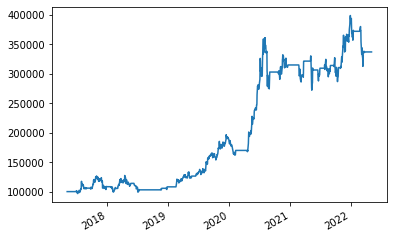

In [82]:
result_bb_rsi._equity_curve.Equity.plot()

### RSI w/ EMA

In [83]:
class RSI_EMA(Strategy):
    
    n1 = 20
    n2 = 50
    n3 = 10
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)

        # 逆勢.改
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)  # (ema1 > ema2) # ema1.shift() )
        signal_short = (rsi.shift() > 70) & (ema1 < ema2) # (ema1 < ema2) # ema1.shift() )
        
        # combine long and short signals
        signal = signal_long.copy()
        signal[signal_short] = -1
        signal = signal.shift(5)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        
        if entry_size > 0:    
            self.buy(size = 0.3) # size: 要用手上多少資金買
#             self.buy()
        elif entry_size < 0: 
#             for trade in self.trades:
#                 trade.close()
            self.sell(size = 1)

In [84]:
bt_rsi_ema = Backtest(_df, RSI_EMA, cash=100000, commission=0.001425)
result_rsi_ema = bt_rsi_ema.run()
bt_rsi_ema.plot()

Row(id='13103', ...)

<AxesSubplot:>

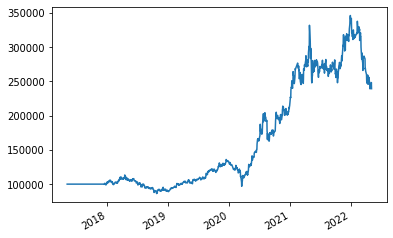

In [85]:
result_rsi_ema._equity_curve.Equity.plot()

In [86]:
result_rsi_ema_2 = bt_rsi_ema.optimize(n1=range(5, 200, 10),
                                       n2=range(5, 200, 10))
result_rsi_ema_2._strategy

/opt/homebrew/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()
/opt/homebrew/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


<Strategy RSI_EMA(n1=5,n2=55)>

<AxesSubplot:>

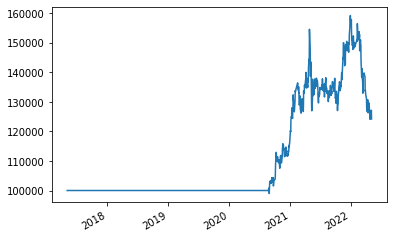

In [87]:
result_rsi_ema_2._equity_curve.Equity.plot()

### MACD

In [88]:
class MACD(Strategy):
    
    short_ema = 0
    long_ema = 0
    
    def init(self):
        super().init()

        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        dif, dea, macd = talib.MACD(close, fastperiod=self.short_ema, slowperiod=self.long_ema)
        
        # Precompute signal
        signal_long = (dif.shift() < macd.shift()) & (dif > macd)
        signal_short = (dif.shift() > macd.shift()) & (dif < macd)

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot
        self.I(lambda x: macd, 'MACD')
        self.I(lambda x: dif, 'DIF')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
            for trade in self.trades:
                trade.close()

In [89]:
bt_macd = Backtest(_df, MACD, cash=100000, commission=0.001425)
result_macd = bt_macd.run(short_ema=12, long_ema=26)
bt_macd.plot()

Row(id='14103', ...)

<AxesSubplot:>

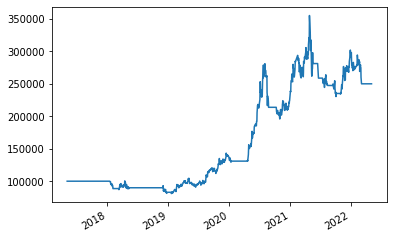

In [90]:
result_macd._equity_curve.Equity.plot()

#### Comparing default params with shorter range btw `short_ema` & `long_ema`

<AxesSubplot:>

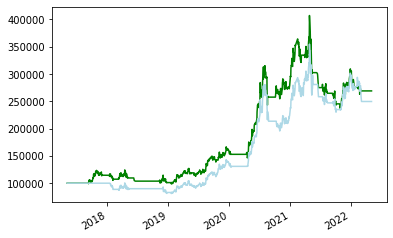

In [91]:
result_macd_1015 = bt_macd.run(short_ema=10, long_ema=15)
result_macd_1015._equity_curve.Equity.plot(color='green')
result_macd._equity_curve.Equity.plot(color='lightblue')

#### Parameters Optimization

In [92]:
result_macd_2 = bt_macd.optimize(short_ema=range(5, 200, 10),
                                 long_ema=range(5, 200, 10))
result_macd_2._strategy

/opt/homebrew/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()
/opt/homebrew/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


<Strategy MACD(short_ema=35,long_ema=85)>

<AxesSubplot:>

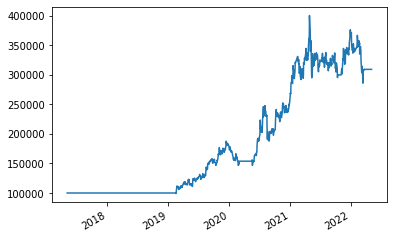

In [93]:
result_macd_2._equity_curve.Equity.plot()